Bike Analysis
Data collected from https://bikeshare.metro.net/about/data/ and https://www.ncei.noaa.gov/cdo-web/

In [862]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import seaborn as sns
from scipy import stats

Data cleaning and importing

In [77]:
rider_dataQ1 = pd.read_csv('metro-trips-2024-q1.csv', parse_dates = ['start_time','end_time'])
rider_dataQ2 = pd.read_csv('metro-trips-2024-q2.csv', parse_dates = ['start_time','end_time'])
rider_dataQ3 = pd.read_csv('metro-trips-2024-q3.csv', parse_dates = ['start_time','end_time'])
rider_dataQ4 = pd.read_csv('metro-trips-2024-q4.csv', parse_dates = ['start_time','end_time'])
rider_data = pd.concat([rider_dataQ1, rider_dataQ2, rider_dataQ3, rider_dataQ4])


In [857]:
# lets add some helpful columns 
rider_data['month'] = rider_data.start_time.dt.month
rider_data['day_of_week'] = rider_data.start_time.dt.dayofweek
rider_data['day_of_year'] = rider_data.start_time.dt.day_of_year
rider_data['week'] = np.ceil(rider_data['day_of_year']/7)


## Q1: What days of the week/ time of year do people ride bikes more? 
We see that people ride more often April to June and then September and October. There is not a significant difference between weekends vs weekdays

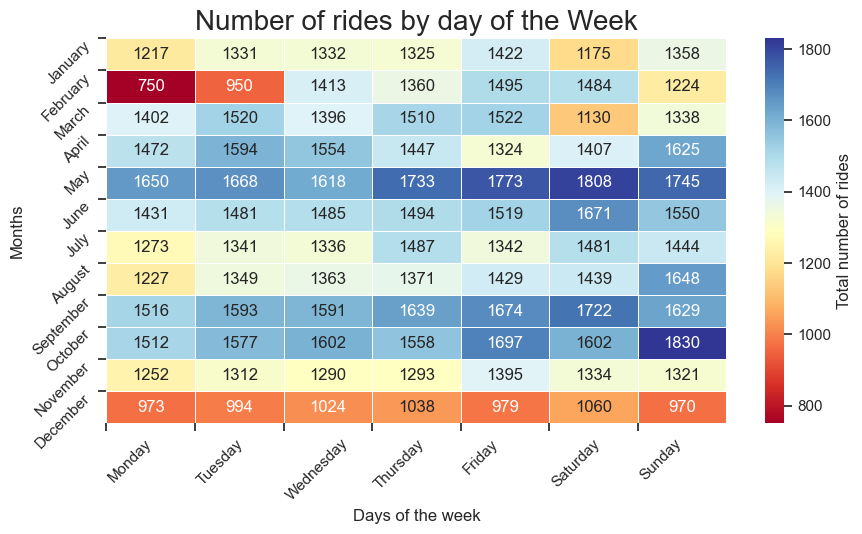

In [1059]:
## I want to group by average ridership by day of the week/month of the year
days = rider_data.groupby(['month', 'day_of_week', 'day_of_year']).size().reset_index() # start by grouping by the month,day of week and day of year to get 366 rows
days.rename(columns= {0:'NumDays'}, inplace=True) #switch the empty column names to NumDays
#print(days_in_days.columns)


days_df = pd.pivot_table(days, index = 'month', values = 'NumDays' ,columns = 'day_of_week', aggfunc = 'mean').round() # now lets make a pivot table of them averaging by the mean

# draw the plots
f, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(days_df, annot=True, fmt="n", linewidths=.5, ax=ax,cmap="RdYlBu", cbar_kws={'label': 'Total number of rides'})

#draw on title, labels, and replace ticks with days/months
plt.title('Number of rides by day of the Week', fontsize = 20)
plt.xlabel('Days of the week')
plt.ylabel('Months')
plt.xticks(np.arange(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           horizontalalignment = 'left', rotation = 45)
plt.yticks(np.arange(12), ['January','February','March','April','May','June','July','August','September','October', 'November', 'December'],
           verticalalignment = 'top', rotation = 45)
plt.show()

In [945]:
# are weekends different than weekdays?
days['weekend'] = days['day_of_week'].isin([5,6]) # split the table by weekdays and weekends

# oh no weekends are NOT normal but weekdays are normal
print(stats.shapiro(days[days['weekend']].NumDays))  # not normal
print(stats.shapiro(days[~days['weekend']].NumDays)) # normal

# so we will do a non-parametric comparison for different sized samples 
sta, pval = stats.mannwhitneyu(days[days['weekend']].NumDays,days[~days['weekend']].NumDays)
print('With a pval of ',round(pval,3), ', there is not evidence of a difference in ridership on weekdays/weekends')


ShapiroResult(statistic=0.945395313190133, pvalue=0.0003122148402078945)
ShapiroResult(statistic=0.9185022573568957, pvalue=9.028205611775197e-11)
With a pval of  0.268 , there is not evidence of a difference in ridership on weekdays/weekends


## Q2: Do people ride more electric vs standard bikes on different days/time of the year
People ride more electric bikes in the beginning of the year, but it drops about 20 weeks into the year where they start to prefer standard bikes until the 40 weeks.

In [830]:
riders_df = rider_data.groupby(['month', 'day_of_week', 'day_of_year', 'bike_type']).size().reset_index() # group the data similiarly to before
riders_df.rename(columns= {0:'NumDays'}, inplace=True)

riders = pd.pivot_table(riders_df, index = 'month', values = 'NumDays' ,columns = ['bike_type', 'day_of_week'], aggfunc = 'mean').round() # just add a new column for bike type

compared = riders['electric']- riders['standard'] # find the difference


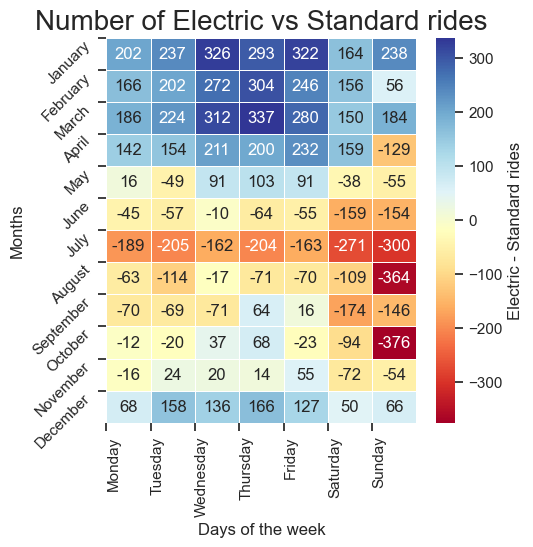

In [948]:
f, ax = plt.subplots(figsize=(5, 5)) # draw the plot
sns.heatmap(compared, annot=True, fmt="n", linewidths=.5, ax=ax,cmap="RdYlBu",cbar_kws={'label': 'Electric - Standard rides'})

plt.title('Number of Electric vs Standard rides', fontsize = 20)
plt.xlabel('Days of the week')
plt.ylabel('Months')
plt.xticks(np.arange(7), ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'],
           horizontalalignment = 'left', rotation = 90)
plt.yticks(np.arange(12), ['January','February','March','April','May','June','July','August','September','October', 'November', 'December'],
           verticalalignment = 'top', rotation = 45)
plt.show()

### Shown in another view ###

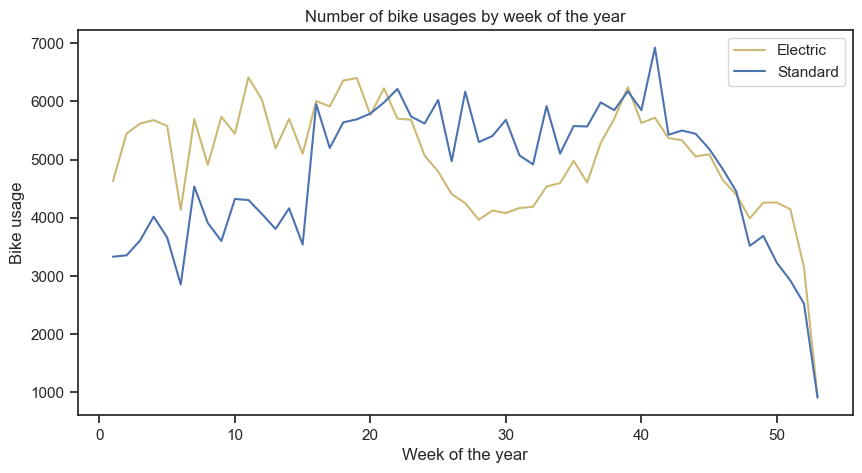

In [1068]:
weekly_rider_df = pd.pivot_table(rider_data, index = 'week', values = 'trip_id',columns = 'bike_type', aggfunc = 'count')
weekly_rider_df.head()
fig, ax = plt.subplots(figsize=(10, 5))

# red dashes, blue squares and green triangles
ax.plot(weekly_rider_df.index, weekly_rider_df['electric'] , 'y-', weekly_rider_df.index, weekly_rider_df['standard'], 'b-')
ax.set_title('Number of bike usages by week of the year')
ax.legend(['Electric','Standard'])
ax.set_ylabel('Bike usage')
ax.set_xlabel('Week of the year')
plt.show()

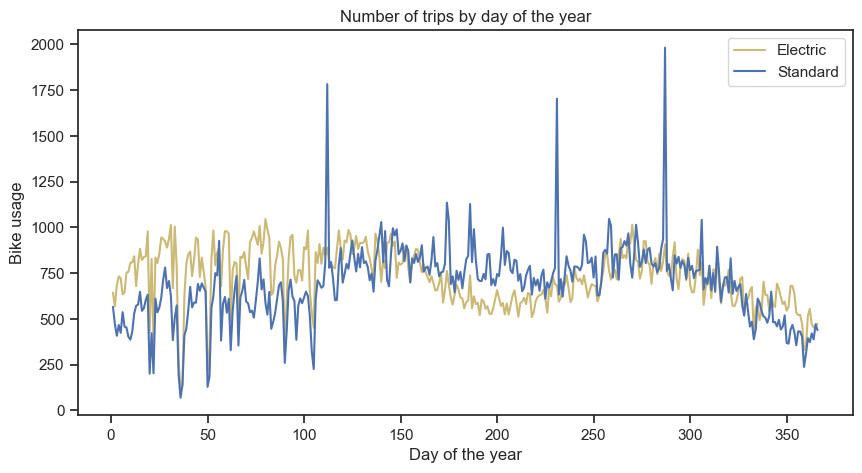

In [1074]:
daily_rider_df = pd.pivot_table(rider_data, index = 'day_of_year', values = 'trip_id',columns = 'bike_type', aggfunc = 'count')
fig, ax = plt.subplots(figsize=(10, 5))

# red dashes, blue squares and green triangles
plt.plot(daily_rider_df.index, daily_rider_df['electric'] , 'y-', daily_rider_df.index, daily_rider_df['standard'], 'b-')
ax.legend(['Electric','Standard'])
ax.set_ylabel('Bike usage')
ax.set_xlabel('Day of the year')
ax.set_title('Number of trips by day of the year')

plt.show()

## Q3: How does weather affect bike usage? Let's combine it with weather data from the Fullerton Airport
We see a strong negative correlation between the amount of daily precipitation and the use of both standard and electric bikes. However, for the daily average temperature we see a strong positive relationship between the use of standard bikes but effectively not correlation to electric bikes. This implies on days that it is warmer people there are more reported bike rides for standard bikes but the relationship is not true for electric bikes

In [956]:
## way more columns that I want so I'm just going to specify what I want here
onlycols = ['DATE','REPORT_TYPE','HourlyDewPointTemperature','HourlyDryBulbTemperature','HourlyPrecipitation','HourlyRelativeHumidity', 'Sunrise','Sunset',
         'DailyAverageDewPointTemperature','DailyAverageDryBulbTemperature','DailyAverageRelativeHumidity','DailyAverageWetBulbTemperature', 'DailyPrecipitation']
weather_df = pd.read_csv('weather_fullerton_2024.csv', usecols = onlycols, low_memory=False,parse_dates = ['DATE'])

In [958]:
#subset the data by only including the daily reports and do some cleaning
daily_df = weather_df[~weather_df['Sunrise'].isna()]
daily_df = daily_df[['DATE', 'Sunrise','Sunset','DailyAverageDryBulbTemperature', 'DailyPrecipitation']]
# Daily precipitation and DryBulb are strings and need to become numbers so I'm going to clean up the few strings that are interfering
daily_df.loc[daily_df['DailyPrecipitation'].isin(['T','Ts']), 'DailyPrecipitation'] = 0 # s
daily_df['DailyPrecipitation']  = daily_df['DailyPrecipitation'].astype('float') # make them floats

daily_df.loc[daily_df['DailyAverageDryBulbTemperature'].isin(['61s']), 'DailyAverageDryBulbTemperature'] = 61
daily_df['DailyAverageDryBulbTemperature']  = daily_df['DailyAverageDryBulbTemperature'].astype('float') # make them floats



daily_df.reset_index(inplace= True) # reset the index
daily_df.index += 1




In [616]:
eachday_df = pd.concat([daily_rider_df, daily_df], axis=1)
eachday_df[['DailyPrecipitation','DailyAverageDryBulbTemperature','standard','electric']].corr()


,DailyPrecipitation,DailyAverageDryBulbTemperature,standard,electric
DailyPrecipitation,1.000000,-0.224324,-0.381914,-0.398585
DailyAverageDryBulbTemperature,-0.224324,1.000000,0.536815,-0.074875
standard,-0.381914,0.536815,1.000000,0.413478
electric,-0.398585,-0.074875,0.413478,1.000000


When we look at temperature and electric bikes close we can see why there is no correlation. There is a huge dip in ridership of electric bikes when the weather is nicer

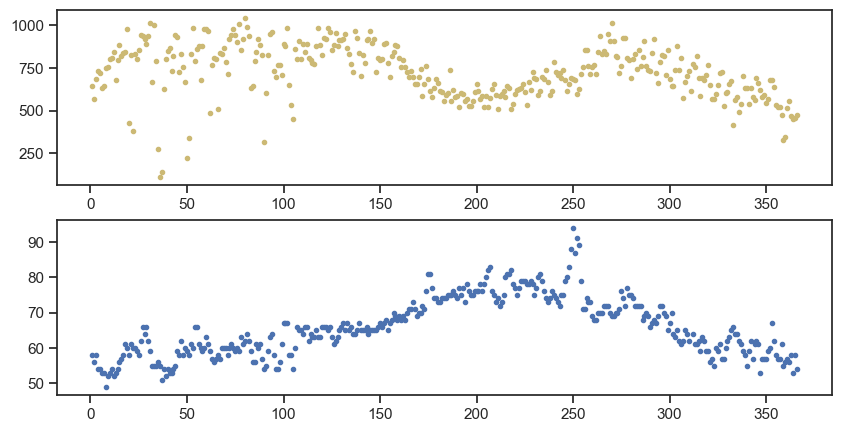

In [962]:
fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 5))
#ax.bar(weekly_rider_pt.index,weekly_rider_pt['electric'])

# red dashes, blue squares and green triangles
ax1.plot(eachday_df.index, eachday_df['electric'] , 'y.')
ax2.plot(eachday_df.index, eachday_df['DailyAverageDryBulbTemperature'], 'b.')
plt.show()

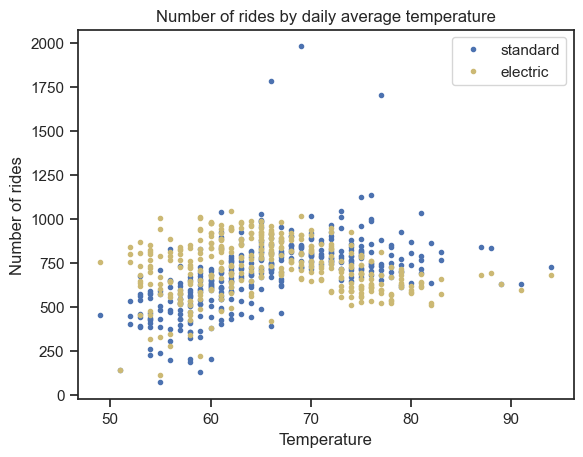

In [1086]:
fig, ax = plt.subplots()

ax = plt.plot(eachday_df['DailyAverageDryBulbTemperature'] ,eachday_df['standard'],  'b.', eachday_df['DailyAverageDryBulbTemperature'] , eachday_df['electric'],'y.')
plt.ylabel('Number of rides')
plt.xlabel('Temperature')
plt.title('Number of rides by daily average temperature')
plt.legend(['standard','electric'])
plt.show()

## Q4: Where are people biking?
Most people are using the bikes for one-way trips (82%). This might be because they are actually doing round trips but they are locking up the bikes between so each ride is one-way. There seems to be a few stations that get a TON of traffic with other stations getting different amounts. The starting stations and ending stations make very similiarly which is what you'd expect given that there needs to be bikes left to get picked up.

In [613]:
# let's get back to some rider data
rider_data.head()
# What is the duration of one-way verse round trip
ow_count = rider_data[rider_data['trip_route_category'] == 'One Way'].shape[0]
rt_count = rider_data[rider_data['trip_route_category'] == 'Round Trip'].shape[0]

ow_rate = round(ow_count/rider_data['trip_route_category'].shape[0]*100,1)
rt_rate = round(rt_count/rider_data['trip_route_category'].shape[0]*100,1)
print('One way rate:', ow_rate, '%', 'Round trip rate: ',rt_rate, '%')


One way rate: 81.8 % Round trip rate:  18.2 %


Let's plot a random sample of the lat and long of the people 

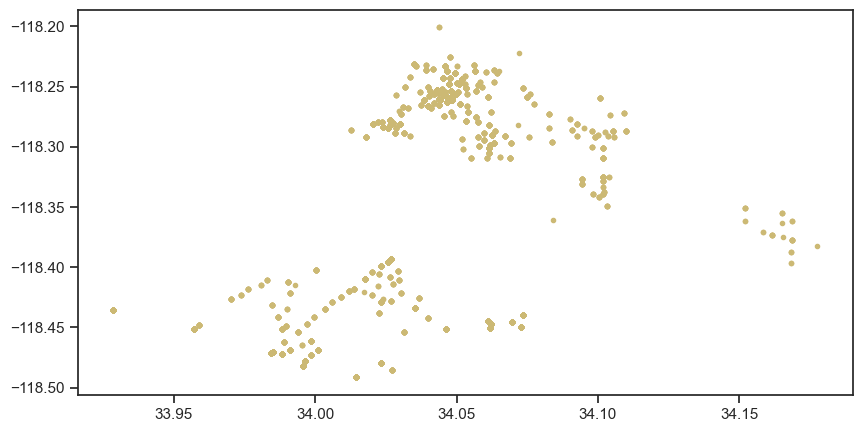

In [997]:
shuffOrd = np.random.permutation(rider_data.index)
subset = shuffOrd[0:1000]

fig, ax = plt.subplots(figsize=(10, 5))
plt.plot(rider_data['start_lat'][subset], rider_data['start_lon'][subset] , 'y.')
plt.show()

This is a rough idea about where some of the stations are located. Here we see two major grouping. One in Santa Monica and one in Downtown LA

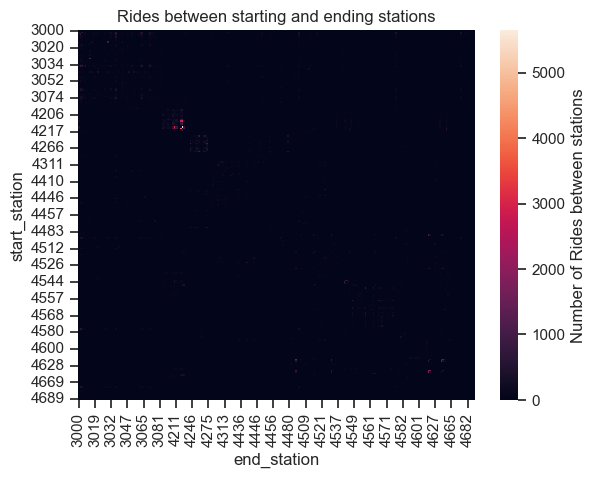

In [1012]:
#Now lets see if there are some stations that get paired together

one_way_trips = pd.pivot_table(rider_data[rider_data['trip_route_category'] == 'One Way'], index = 'start_station', values = 'trip_id',columns = 'end_station', aggfunc = 'count').fillna(0)
ax  = sns.heatmap(one_way_trips,cbar_kws={'label': 'Number of Rides between stations'})
ax.set_title('Rides between starting and ending stations')
plt.show()


Okay there are SO MANY trips with low numbers and a few with very high number so let's get rid of some of those less common stations. Only including stations that are used more than 3000 times in a year

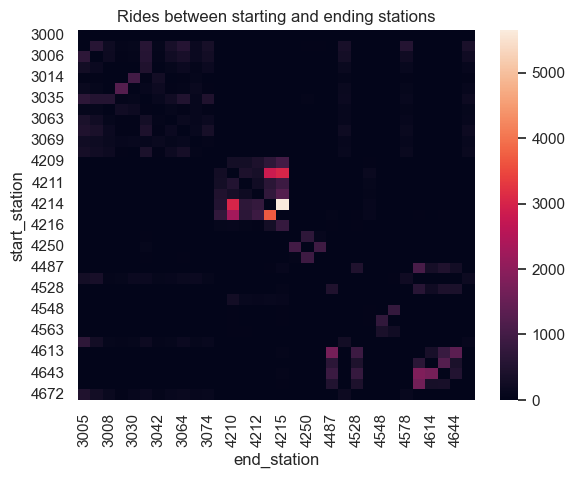

In [1028]:
st = []
en = []

for i in one_way_trips.index:
    if one_way_trips.loc[i].sum() > 3000:
        en.append(i)

for i in one_way_trips.columns:
    if one_way_trips[i].sum() > 3000:
        st.append(i)  

ax = sns.heatmap(one_way_trips.loc[st, en])
ax.set_title('Rides between starting and ending stations')
plt.show()

okay it seems pretty balanced (symmetrical along the diagonal) so stations are getting used both as starting stations and as ending stations. 

 Let's plot the frequency of different stations to be the starting station


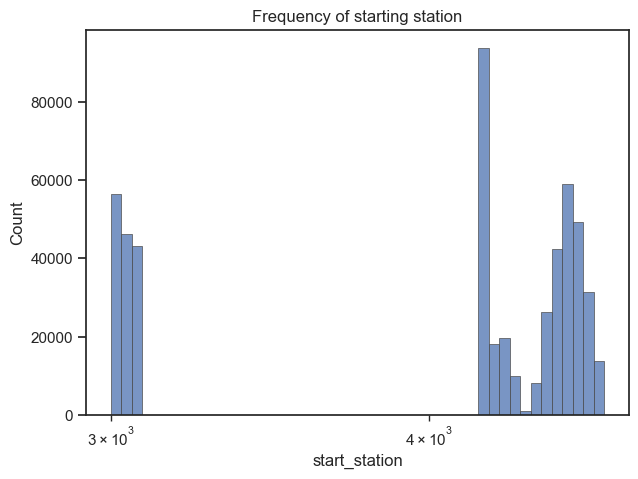

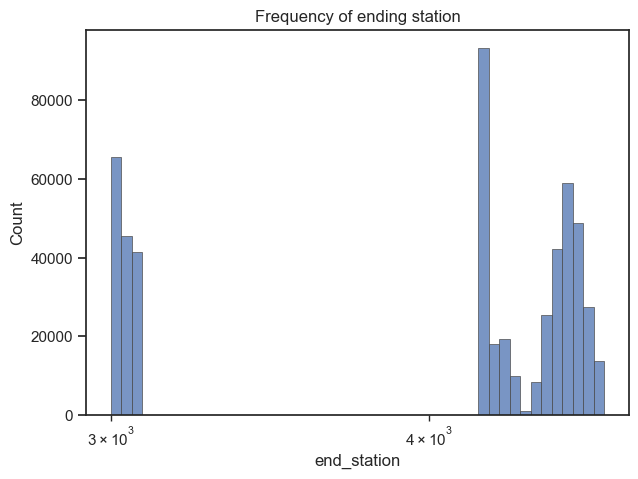

In [1044]:
sns.set_theme(style="ticks")


fig1, ax1 = plt.subplots(figsize=(7, 5))
sns.despine(f)

ax1 = sns.histplot(
    rider_data,
    x="start_station",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)

ax1.set_title('Frequency of starting station')
#ax.set_xticks([500, 1000, 2000, 5000, 10000])

fig2, ax2 = plt.subplots(figsize=(7, 5))
sns.despine(f)

ax2 = sns.histplot(
    rider_data,
    x="end_station",
    edgecolor=".3",
    linewidth=.5,
    log_scale=True,
)
ax2.set_title('Frequency of ending station')
plt.show()